In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [2]:
words = open('names.txt', 'r').read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [3]:
len(words)

32033

In [4]:
chars = sorted(list(set(''.join(words))))
print(chars)
stoi = {s: i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s,i in stoi.items()}
print(itos)
vocab_size = len(itos)

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


### build the dataset

In [5]:
device = torch.device('cpu')
# device = torch.device('cuda')

In [6]:
block_size = 3
def build_dataset(words):
    X, Y = [], []
    for w in words:
        # print(w)
        context = [0]*block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[i] for i in context), '---->', itos[ix])
            context = context[1:] + [ix]

    X = torch.tensor(X).to(device)
    Y = torch.tensor(Y).to(device)
    print(X.dtype, X.shape, Y.dtype, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr, Ytr = build_dataset(words[:n1])        # 80%
Xdev, Ydev = build_dataset(words[n1:n2])    # 10%
Xte, Yte = build_dataset(words[n2:])        # 10%

torch.int64 torch.Size([182625, 3]) torch.int64 torch.Size([182625])
torch.int64 torch.Size([22655, 3]) torch.int64 torch.Size([22655])
torch.int64 torch.Size([22866, 3]) torch.int64 torch.Size([22866])


### implementing cross entropy loss

In [7]:
n_embd = 10 # dimensionality of the character embedding vectors
n_hidden = 200 # number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size,n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3) / ((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))
parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

12297


In [8]:
def cmp(s, dt, t):
    ex = torch.all(dt == t.grad).item()
    app = torch.allclose(dt, t.grad)
    maxdiff = (dt - t.grad).abs().max().item()
    print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [9]:
import torch
import torch.nn.functional as F

batch_size = 32
ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
Xb = Xtr[ix]
Yb = Ytr[ix]

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True
    p.grad = None

# forward pass
emb = C[Xb] # embed the characters into vectors - (batch_size x block_size x n_embed)
embcat = emb.view(emb.shape[0], -1) # concatenate the vectors - (batch_size x (block_size x n_embed))
hprebn = embcat @ W1 + b1 # hidden layer pre-activation - (batch_size x n_hidden)
bnmeani = 1.0/batch_size * hprebn.sum(dim=0, keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff ** 2
bnvar = 1.0/(batch_size-1) * bndiff2.sum(dim=0, keepdim=True)
bnstdinv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnstdinv
hpreact = bngain * bnraw + bnbias # (batch_size x n_hidden)
h = torch.tanh(hpreact) # hidden layer - (batch_size x n_hidden)
logits = h @ W2 + b2 # output layer - (batch_size x vocab_size)
# logits = torch.rand((batch_size, 27), requires_grad=True)
logitsmax = logits.max(dim=1, keepdim=True).values # (batch_size x vocab_size)
normlogits = logits - logitsmax # (batch_size x vocab_size)
counts = normlogits.exp() # (batch_size x vocab_size)
countsum = counts.sum(dim=1, keepdim=True) # (batch_size x 1)
countsuminv = countsum ** -1 # (batch_size x 1)
probs = counts * countsuminv # (batch_size x vocab_size)
logprobs = probs.log() # (batch_size x vocab_size)
loss = -logprobs[torch.arange(batch_size), Yb].mean() # 1

for t in [emb, C, hprebn, embcat, W1, b1, bnmeani, bndiff, bndiff2, bnvar, bndiff, bnstdinv, bngain, bnraw, bnbias, hpreact, h, W2, b2, logits, logitsmax, normlogits, counts, countsum, countsuminv, probs, logprobs, loss]:
    t.retain_grad()
loss.backward()
# backward pass
dlogprops = torch.zeros(logprobs.shape)
dlogprops[torch.arange(batch_size), Yb] = -1.0/batch_size
dprobs = (1.0 / probs) * dlogprops
dcountsuminv = (counts * dprobs).sum(dim=1, keepdim=True)
dcountsum = (-countsum**-2) * dcountsuminv
dcounts = torch.ones_like(counts) * dcountsum
dcounts += countsuminv * dprobs
dnormlogits = counts * dcounts
dlogitsmax = -dnormlogits.sum(dim=1, keepdim=True) # for: -logitsmax in: normlogits = logits - logitsmax
dlogits = F.one_hot(logits.argmax(dim=1), num_classes=logits.shape[1]) * dlogitsmax
dlogits += dnormlogits.clone()
dh = dlogits @ W2.T
dW2 = h.T @ dlogits
db2 = dlogits.sum(dim=0, keepdim=True)
dhpreact = (1.0 - h**2) * dh
# dhpreact = (1.0/(torch.arccosh(hpreact)**2)) * dh
dbngain = (bnraw * dhpreact).sum(dim=0, keepdim=True)
dbnraw = bngain * dhpreact
dbnbias = dhpreact.sum(dim=0, keepdim=True)
dbnstdinv = (bndiff * dbnraw).sum(dim=0, keepdim=True)
dbnvar = -0.5*(bnvar + 1e-5)**-1.5 * dbnstdinv
dbndiff2 = 1.0/(batch_size-1) * torch.ones_like(bndiff2) * dbnvar
dbndiff = bnstdinv * dbnraw
dbndiff += 2*bndiff * dbndiff2
dbnmeani = -dbndiff.sum(dim=0, keepdim=True)
dhprebn = dbndiff + 1.0/batch_size * torch.ones_like(hprebn) * dbnmeani
dembcat = dhprebn @ W1.T
dW1 = embcat.T @ dhprebn
db1 = dhprebn.sum(dim=0, keepdim=True)
demb = dembcat.view(emb.shape)
dC = torch.zeros_like(C)
for i in range(batch_size):
    for j in range(block_size):
        k = Xb[i,j]
        dC[k] += demb[i, j]

cmp('dlogprops', dlogprops, logprobs)
cmp('dprobs', dprobs, probs)
cmp('dcountsuminv', dcountsuminv, countsuminv)
cmp('dcountsum', dcountsum, countsum)
cmp('dcounts', dcounts, counts)
cmp('dnormlogits', dnormlogits, normlogits)
cmp('dlogitsmax', dlogitsmax, logitsmax)
cmp('dlogits', dlogits, logits)
cmp('dh', dh, h)
cmp('dW2', dW2, W2)
cmp('db2', db2, b2)
cmp('dhpreact', dhpreact, hpreact)
cmp('dbngain', dbngain, bngain)
cmp('dbnraw', dbnraw, bnraw)
cmp('dbnbias', dbnbias, bnbias)
cmp('dbnstdinv', dbnstdinv, bnstdinv)
cmp('dbnvar', dbnvar, bnvar)
cmp('dbndiff2', dbndiff2, bndiff2)
cmp('dbndiff', dbndiff, bndiff)
cmp('dbnmeani', dbnmeani, bnmeani)
cmp('dhprebn', dhprebn, hprebn)
cmp('dembcat', dembcat, embcat)
cmp('dW1', dW1, W1)
cmp('db1', db1, b1)
cmp('demb', demb, emb)
cmp('dC', dC, C)

12297
dlogprops       | exact: True  | approximate: True  | maxdiff: 0.0
dprobs          | exact: True  | approximate: True  | maxdiff: 0.0
dcountsuminv    | exact: True  | approximate: True  | maxdiff: 0.0
dcountsum       | exact: True  | approximate: True  | maxdiff: 0.0
dcounts         | exact: True  | approximate: True  | maxdiff: 0.0
dnormlogits     | exact: True  | approximate: True  | maxdiff: 0.0
dlogitsmax      | exact: True  | approximate: True  | maxdiff: 0.0
dlogits         | exact: True  | approximate: True  | maxdiff: 0.0
dh              | exact: True  | approximate: True  | maxdiff: 0.0
dW2             | exact: True  | approximate: True  | maxdiff: 0.0
db2             | exact: True  | approximate: True  | maxdiff: 0.0
dhpreact        | exact: False | approximate: True  | maxdiff: 5.820766091346741e-11
dbngain         | exact: False | approximate: True  | maxdiff: 2.3283064365386963e-10
dbnraw          | exact: False | approximate: True  | maxdiff: 5.820766091346741e-11
d

In [10]:
loss_fast = F.cross_entropy(logits, Yb)
print(loss.item(), loss_fast.item(), 'diff:', (loss - loss_fast).item())


3.3146891593933105 3.3146886825561523 diff: 4.76837158203125e-07


In [11]:
print(logits.shape, dlogits.shape)
dlogits_fast = F.softmax(logits, dim=1)
dlogits_fast[torch.arange(batch_size), Yb] -= 1
dlogits_fast /= batch_size
print('diff:', (dlogits - dlogits_fast).max().item())

torch.Size([32, 27]) torch.Size([32, 27])
diff: 6.6356733441352844e-09


tensor([ 0.0011, -0.0298,  0.0011,  0.0012,  0.0012,  0.0011,  0.0011,  0.0011,
         0.0012,  0.0012,  0.0013,  0.0010,  0.0011,  0.0010,  0.0011,  0.0011,
         0.0012,  0.0010,  0.0009,  0.0011,  0.0014,  0.0013,  0.0013,  0.0011,
         0.0010,  0.0013,  0.0013], grad_fn=<SelectBackward0>)

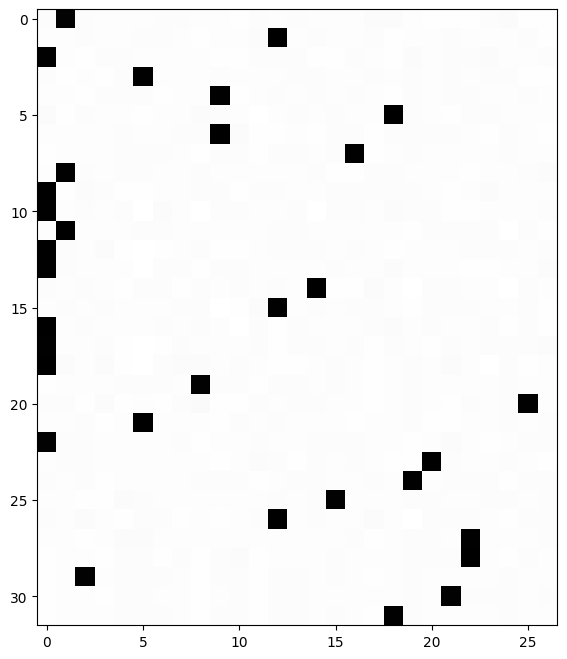

In [12]:
plt.figure(figsize=(8,8))
plt.imshow(dlogits.detach(), cmap='gray')
dlogits[0]

In [22]:
dbngain_fast = (((hprebn - hprebn.mean(dim=0, keepdim=True)) / hprebn.std(dim=0, keepdim=True)) * dhpreact).sum(dim=0, keepdim=True)
dbnbias_fast = dhpreact.sum(dim=0, keepdim=True)
# dhprebn_fast += bngain * (hprebn - bnmeani) * -bnstdinv**2 * 2/(batch_size-1) * (hprebn - bnmeani).sum(dim=0, keepdim=True) * (1.0 - 1.0/batch_size) * dhpreact
print('bngain diff:', (dbngain - dbngain_fast).max().item())
print('bnbias diff:', (dbnbias - dbnbias_fast).max().item())
print(dhprebn.shape, bngain.shape, hprebn.shape)

bngain diff: 6.05359673500061e-09
bnbias diff: 0.0
torch.Size([32, 200]) torch.Size([1, 200]) torch.Size([32, 200])


In [18]:
dbnvar_fast = (dhpreact * (-0.5*bngain * bndiff * bnvar**-1.5)).sum(dim=0, keepdim=True)
print(dbnvar_fast.shape, dbnvar.shape)
print('bnvar diff:', ((dbnvar_fast - dbnvar).max().item()))

torch.Size([1, 200]) torch.Size([1, 200])
bnvar diff: 7.043126970529556e-09


In [19]:
dbnmean_fast = (dhpreact * -bngain * bnvar**-0.5).sum(dim=0, keepdim=True)
print('bnmean diff:', (dbnmean_fast - dbnmeani).max().item())

bnmean diff: 2.60770320892334e-08


In [21]:
temp1 = dhpreact * bngain * bnvar**-0.5
temp2 = dbnmean_fast * 1/batch_size * torch.ones_like(hprebn)
temp3 = dbnvar_fast * 2/(batch_size-1) * bndiff
dhprebn_fast = temp1 + temp2 + temp3
print(dhprebn.shape, dhprebn_fast.shape, bngain.shape, hprebn.shape)
print('hprebn diff:', (dhprebn - dhprebn_fast).max().item())

torch.Size([32, 200]) torch.Size([32, 200]) torch.Size([1, 200]) torch.Size([32, 200])
hprebn diff: 5.820766091346741e-09


In [27]:
import torch
import torch.nn.functional as F

batch_size = 32
ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
Xb = Xtr[ix]
Yb = Ytr[ix]

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True    

# forward pass
emb = C[Xb] # embed the characters into vectors - (batch_size x block_size x n_embed)
embcat = emb.view(emb.shape[0], -1) # concatenate the vectors - (batch_size x (block_size x n_embed))
hprebn = embcat @ W1 + b1 # hidden layer pre-activation - (batch_size x n_hidden)
hpreact = bngain * (hprebn - hprebn.mean(dim=0, keepdim=True))/hprebn.std(dim=0, keepdim=True) + bnbias # batch-norm
h = torch.tanh(hpreact) # hidden layer - (batch_size x n_hidden)
logits = h @ W2 + b2 # output layer - (batch_size x vocab_size)
loss = F.cross_entropy(logits, Yb)


for t in [C, W1, b1, W2, b2, bngain, bnbias, emb, embcat, hprebn, hpreact, h, logits, loss]:
    t.retain_grad()
loss.backward()

# backward pass
dlogits = F.softmax(logits, dim=1)
dlogits[torch.arange(batch_size), Yb] -= 1
dlogits /= batch_size
# output layer
dh = dlogits @ W2.T
dW2 = h.T @ dlogits
db2 = dlogits.sum(dim=0, keepdim=True)
# tanh
dhpreact = (1.0 - h**2) * dh
# batch-norm
bndiff = hprebn - hprebn.mean(dim=0, keepdim=True)
bnvar = hprebn.var(dim=0, keepdim=True)
dbngain = ((bndiff / hprebn.std(dim=0, keepdim=True)) * dhpreact).sum(dim=0, keepdim=True)
dbnbias = dhpreact.sum(dim=0, keepdim=True)
dbnvar = (dhpreact * (-0.5*bngain * bndiff * bnvar**-1.5)).sum(dim=0, keepdim=True)
dbnmean = (dhpreact * -bngain * bnvar**-0.5).sum(dim=0, keepdim=True)
temp1 = dhpreact * bngain * bnvar**-0.5
temp2 = dbnmean * 1/batch_size * torch.ones_like(hprebn)
temp3 = dbnvar * 2/(batch_size-1) * bndiff
dhprebn = temp1 + temp2 + temp3
# hidden layers
dembcat = dhprebn @ W1.T
dW1 = embcat.T @ dhprebn
db1 = dhprebn.sum(dim=0, keepdim=True)
# input layer
demb = dembcat.view(emb.shape)
dC = torch.zeros_like(C)
for i in range(batch_size):
    for j in range(block_size):
        k = Xb[i,j]
        dC[k] += demb[i, j]


cmp('dlogits', dlogits, logits)
cmp('dh', dh, h)
cmp('dW2', dW2, W2)
cmp('db2', db2, b2)
cmp('dhpreact', dhpreact, hpreact)
cmp('dbngain', dbngain, bngain)
cmp('dbnraw', dbnraw, bnraw)
cmp('dbnbias', dbnbias, bnbias)
cmp('dhprebn', dhprebn, hprebn)
cmp('dembcat', dembcat, embcat)
cmp('dW1', dW1, W1)
cmp('db1', db1, b1)
cmp('demb', demb, emb)
cmp('dC', dC, C)

12297
dlogits         | exact: False | approximate: True  | maxdiff: 1.862645149230957e-09
dh              | exact: False | approximate: True  | maxdiff: 1.7462298274040222e-10
dW2             | exact: False | approximate: True  | maxdiff: 1.4901161193847656e-08
db2             | exact: False | approximate: True  | maxdiff: 7.450580596923828e-09
dhpreact        | exact: False | approximate: True  | maxdiff: 1.1641532182693481e-10
dbngain         | exact: False | approximate: True  | maxdiff: 2.9103830456733704e-10
dbnraw          | exact: False | approximate: True  | maxdiff: 5.820766091346741e-11
dbnbias         | exact: False | approximate: True  | maxdiff: 4.656612873077393e-10
dhprebn         | exact: False | approximate: True  | maxdiff: 1.4551915228366852e-10
dembcat         | exact: False | approximate: True  | maxdiff: 5.820766091346741e-10
dW1             | exact: False | approximate: True  | maxdiff: 9.313225746154785e-10
db1             | exact: False | approximate: True  | 

In [ ]:
import torch
import torch.nn.functional as F

batch_size = 32
ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
Xb = Xtr[ix]
Yb = Ytr[ix]

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True
    p.grad = None

# forward pass
emb = C[Xb] # embed the characters into vectors - (batch_size x block_size x n_embed)
embcat = emb.view(emb.shape[0], -1) # concatenate the vectors - (batch_size x (block_size x n_embed))
hprebn = embcat @ W1 + b1 # hidden layer pre-activation - (batch_size x n_hidden)
hpreact = bngain * (hprebn - hprebn.mean(dim=0, keepdim=True))/hprebn.std(dim=0, keepdim=True) + bnbias # batch-norm
h = torch.tanh(hpreact) # hidden layer - (batch_size x n_hidden)
logits = h @ W2 + b2 # output layer - (batch_size x vocab_size)
loss = F.cross_entropy(logits, Yb)


for t in [C, W1, b1, W2, b2, bngain, bnbias, emb, embcat, hprebn, hpreact, h, logits, loss]:
    t.retain_grad()
loss.backward()

# backward pass
dlogits = F.softmax(logits, dim=1)
dlogits[torch.arange(batch_size), Yb] -= 1
dlogits /= batch_size
# output layer
dh = dlogits @ W2.T
dW2 = h.T @ dlogits
db2 = dlogits.sum(dim=0, keepdim=True)
# tanh
dhpreact = (1.0 - h**2) * dh
# batch-norm
bndiff = hprebn - hprebn.mean(dim=0, keepdim=True)
bnvar = hprebn.var(dim=0, keepdim=True)
dbngain = ((bndiff / hprebn.std(dim=0, keepdim=True)) * dhpreact).sum(dim=0, keepdim=True)
dbnbias = dhpreact.sum(dim=0, keepdim=True)
dbnvar = (dhpreact * (-0.5*bngain * bndiff * bnvar**-1.5)).sum(dim=0, keepdim=True)
dbnmean = (dhpreact * -bngain * bnvar**-0.5).sum(dim=0, keepdim=True)
temp1 = dhpreact * bngain * bnvar**-0.5
temp2 = dbnmean * 1/batch_size * torch.ones_like(hprebn)
temp3 = dbnvar * 2/(batch_size-1) * bndiff
dhprebn = temp1 + temp2 + temp3
# hidden layers
dembcat = dhprebn @ W1.T
dW1 = embcat.T @ dhprebn
db1 = dhprebn.sum(dim=0, keepdim=True)
# input layer
demb = dembcat.view(emb.shape)
dC = torch.zeros_like(C)
for i in range(batch_size):
    for j in range(block_size):
        k = Xb[i,j]
        dC[k] += demb[i, j]


cmp('dlogits', dlogits, logits)
cmp('dh', dh, h)
cmp('dW2', dW2, W2)
cmp('db2', db2, b2)
cmp('dhpreact', dhpreact, hpreact)
cmp('dbngain', dbngain, bngain)
cmp('dbnraw', dbnraw, bnraw)
cmp('dbnbias', dbnbias, bnbias)
cmp('dhprebn', dhprebn, hprebn)
cmp('dembcat', dembcat, embcat)
cmp('dW1', dW1, W1)
cmp('db1', db1, b1)
cmp('demb', demb, emb)
cmp('dC', dC, C)